In [1]:
%matplotlib inline

import datetime as dt
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

from datetime import datetime
from tqdm.notebook import tqdm

# Data Understanding

In [2]:
# Loading dataset.

custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%y %H:%M")

df = pd.read_csv('datasets/customer_supermarket.csv', sep='\t', decimal=',',
                 parse_dates=['BasketDate'], date_parser=custom_date_parser, index_col=0)

df['CustomerID'] = df['CustomerID'].astype(float)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  float64       
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.4+ MB


In [4]:
df.isnull().sum()

BasketID               0
BasketDate             0
Sale                   0
CustomerID         65080
CustomerCountry        0
ProdID                 0
ProdDescr            753
Qta                    0
dtype: int64

13% of CustomerIDs are null, 0.15% of ProdDescr are null.

In [5]:
df.describe()

,Sale,CustomerID,Qta
count,471910.000000,406830.000000,471910.000000
mean,4.030945,15287.684160,10.716533
std,83.769380,1713.603074,231.355136
min,-11062.060000,12346.000000,-80995.000000
25%,1.250000,13953.000000,1.000000
50%,2.080000,15152.000000,4.000000
75%,3.750000,16791.000000,12.000000
max,38970.000000,18287.000000,80995.000000


Detected anomalies:
- float customer IDs
- negative sales;
- negative quantities;
- huge maximum sale;
- huge maximum quantity.

In [6]:
df[df['Sale'] < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1
299984,A563187,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1


The 2 records with negative sale have a leading 'A' on the BasketID, that we suppose means "aborted transaction".

In [7]:
df[df['Qta'] < 0].head()

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
141,C536379,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,D,Discount,-1
154,C536383,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,35004C,SET OF 3 COLOURED FLYING DUCKS,-1
235,C536391,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,22556,PLASTERS IN TIN CIRCUS PARADE,-12
236,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21984,PACK OF 12 PINK PAISLEY TISSUES,-24
237,C536391,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24


All the records with negative quantities have BaskedIDs with a leading 'C', that we assume means "canceled order".
The order's entries have been modified in-place, so...

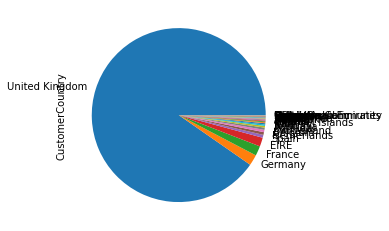

In [8]:
# Customers' nationalities.

countries = df['CustomerCountry'].value_counts()
ax = countries.plot.pie()

All the countries are real, but there are 340 unspecified records' countries.

## Data distribution and quality

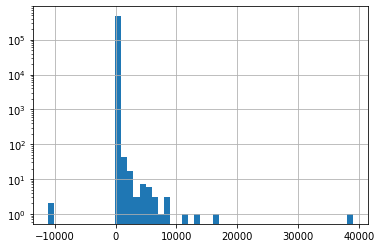

In [9]:
# Sales distribution.

ax = df.Sale.hist(log=True, bins=50)

The majority of purchases have low price (up to 20£), but there are few above 10000£, let's see them.

In [10]:
df[abs(df['Sale']) > 10000]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
16356,C537651,2010-12-07 15:49:00,13541.33,NaN,United Kingdom,AMAZONFEE,AMAZON FEE,-1
43703,C540118,2011-01-05 09:57:00,16453.71,NaN,United Kingdom,AMAZONFEE,AMAZON FEE,-1
222681,C556445,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,M,Manual,-1
299983,A563186,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1
299984,A563187,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1
524601,C580604,2011-12-05 11:35:00,11586.50,NaN,United Kingdom,AMAZONFEE,AMAZON FEE,-1


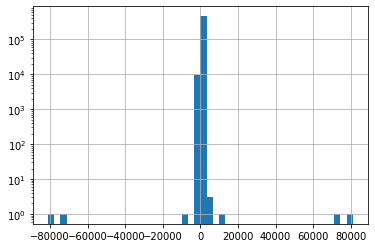

In [11]:
# Qta distribution.

ax = df.Qta.hist(log=True, bins=50)

The majority of purchases have low quantities, except for 4 symmetrical values above 60000 units: let's see them.

In [12]:
df[abs(df['Qta']) > 60000]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
61619,541431,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215
61624,C541433,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215
540421,581483,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,23843,"PAPER CRAFT , LITTLE BIRDIE",80995
540422,C581484,2011-12-09 09:27:00,2.08,16446.0,United Kingdom,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995


It seems like two orders have been canceled and made again.

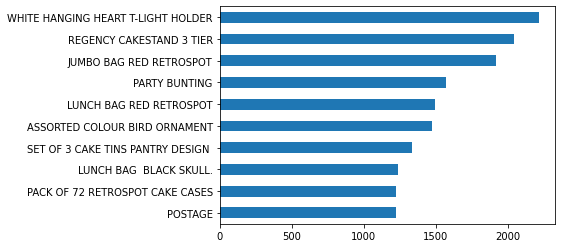

In [13]:
# Top-10 frequent products.

ax = df['ProdDescr'].value_counts().head(10).plot(kind='barh')
ax.invert_yaxis()

The first 9 most sold products are legit ones, but the 10th is "postage", that we assume is related to the shipping, and we're not considering it as a valid product.

After a deeper analysis we've detected some unusual and erroneous ProdID and ProdDescr, and we've put them in two files: blacklist_prod_descr.csv and blacklist_prod_id.csv. An example is a descrition that mocks a colleague, also with typos: "alan hodge cant mamage this section".

Analyzing the data, we also found this relation: (ProdDescr = null) $\Rightarrow$ (CustomerID = null $\land$ Sale = 0).

# Data preparation

## New features

We want to analyze the customers' behavior on the day of the week.

In [14]:
df['BasketDay'] = df['BasketDate'].dt.day_name()

As said before, the BasketID starting with a 'C' have been considered canceled. We add a new boolean field "Canceled" to keep track of them, then we remove the 'C' from the BasketID, and we reverse the quantity for further simplicity.

In [15]:
canceled = 'C'
df['Canceled'] = df['BasketID'].apply(lambda x : x.startswith(canceled))
df['BasketID'] = df['BasketID'].apply(lambda x : x[1:] if x.startswith(canceled) else x)
df['Qta'] = np.where(df['Canceled'], abs(df['Qta']), df['Qta'])

## Data cleaning

Given the high number of null CustomerIDs, we see if we can recover some of them among the single purchase's transactions.

In [16]:
# Check that there are useful BasketIDs for recovering the CustomerID

recover_basket = []
'''
last_basket = None
with tqdm(total=len(df)) as pbar:  
    for index, row in df.iterrows():
        pbar.update(1)
        if last_basket != row['BasketID']:
            last_basket = row['BasketID']
            data = df[df['BasketID'] == row['BasketID']]
            all_nan = data['CustomerID'].isnull().values.all()
            any_nan = data['CustomerID'].isnull().values.any()
            if (all_nan == False and any_nan == True): 
                recover_basket.append(row['BasketID'])
recover_basket'''

"\nlast_basket = None\nwith tqdm(total=len(df)) as pbar:  \n    for index, row in df.iterrows():\n        pbar.update(1)\n        if last_basket != row['BasketID']:\n            last_basket = row['BasketID']\n            data = df[df['BasketID'] == row['BasketID']]\n            all_nan = data['CustomerID'].isnull().values.all()\n            any_nan = data['CustomerID'].isnull().values.any()\n            if (all_nan == False and any_nan == True): \n                recover_basket.append(row['BasketID'])\nrecover_basket"

We cannot recover any CustomerID, and since we must analyze the customer behavior, and we can't understand if two purchases belong to the same customer, we drop the null values.

In [17]:
df.dropna(subset=['CustomerID'], inplace=True)

Now that we removed the null values, we check if we can remove the decimal part on CustomerID

In [18]:
np.any(np.where(df['CustomerID'].apply(lambda x: x.is_integer()), 0, 1))

False

There's no CustomerID that uses the decimal part, hence the attribute is an integer.

In [19]:
df['CustomerID'] = df['CustomerID'].astype(int)

Note that, from the relation (ProdDescr = null) $\Rightarrow$ (CustomerID = null $\land$ Sale = 0), if we remove the null CustomerIDs, we remove also all the null ProdDescr.

In [20]:
df['ProdDescr'].isnull().any()

False

The aborted transactions are already dropped because of their null CustomerID.

In [21]:
df[df['Sale'] < 0]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,BasketDay,Canceled


In [22]:
df['BasketID'] = df['BasketID'].astype(int)

We compute the total price of every row.

In [23]:
df['Total'] = df['Sale'] * df['Qta']

Then we remove the rows with bad ProdDescr and ProdID.

In [24]:
# To find bad descriptions.
#df['ProdDescr'].value_counts().to_csv('prodlist.csv')

In [25]:
with open('blacklists/prod_descr.csv') as f:
    blacklist = [line.strip() for line in f]

df = df[~df['ProdDescr'].isin(blacklist)]

In [26]:
# If len < 5 or > 6, probably not a valid product. We made another blacklist.

with open('blacklists/prod_id.csv') as f:
    blacklist = [line.strip() for line in f]

df = df[~df['ProdID'].isin(blacklist)]

We found few zero prices, and in most of the cases, also null ProdDescr. We decided to get rid of them.

In [27]:
df = df[~(df['Sale'] == 0)]

There are still too small values of Sale (less than 1 penny). We remove them.

In [28]:
df = df[~(df['Sale'] < 0.01)]

5.27% of BasketIDs removed.

In [29]:
# Percentage for each country dropped.

countries_after = df['CustomerCountry'].value_counts()
dropped = (1 - countries_after.divide(countries)) * 100
dropped

Australia                0.397141
Austria                  3.491272
Bahrain                 10.526316
Belgium                  4.736588
Brazil                   0.000000
Canada                   0.662252
Channel Islands          0.659631
Cyprus                   0.482315
Czech Republic           6.666667
Denmark                  3.598972
EIRE                     5.700409
European Community       4.918033
Finland                  6.043165
France                   4.187683
Germany                  4.212744
Greece                   2.739726
Hong Kong                     NaN
Iceland                  0.000000
Israel                   7.063197
Italy                    2.490660
Japan                    0.837989
Lebanon                  0.000000
Lithuania                0.000000
Malta                    3.149606
Netherlands              1.897933
Norway                   2.486188
Poland                   1.466276
Portugal                 3.946488
RSA                      1.724138
Saudi Arabia  

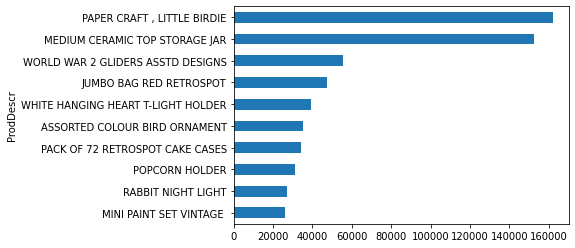

In [30]:
# New top-10 products.

grouped_data = df.groupby(['ProdDescr']).agg({'Qta': 'sum'})

ax = grouped_data['Qta'].nlargest(10).plot(kind='barh')
ax.invert_yaxis()

In [31]:
df.describe()

,BasketID,Sale,CustomerID,Qta,Total
count,404876.000000,404876.000000,404876.000000,404876.000000,404876.000000
mean,560584.082717,2.901366,15295.253282,13.403704,22.810614
std,13106.540726,4.430949,1710.404209,248.399725,422.673214
min,536365.000000,0.030000,12346.000000,1.000000,0.060000
25%,549130.000000,1.250000,13969.000000,2.000000,4.680000
50%,561873.500000,1.950000,15159.000000,5.000000,11.700000
75%,572066.000000,3.750000,16794.000000,12.000000,19.800000
max,581587.000000,649.500000,18287.000000,80995.000000,168469.600000


<AxesSubplot:>

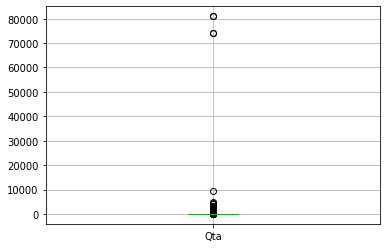

In [32]:
df.boxplot(column='Qta')

We delete the strange 4 canceled and re-done orders that we saw before.

In [33]:
df.drop(df[df.Qta > 60000].index, inplace=True)

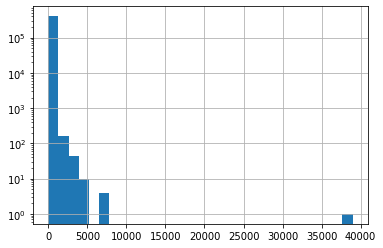

In [34]:
ax = df.Total.hist(log=True, bins=30)

There's one order with a very high total.

In [35]:
df[df['Total'] > 35000]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta,BasketDay,Canceled,Total
222671,556444,2011-06-10 15:28:00,649.5,15098,United Kingdom,22502,PICNIC BASKET WICKER 60 PIECES,60,Friday,False,38970.0


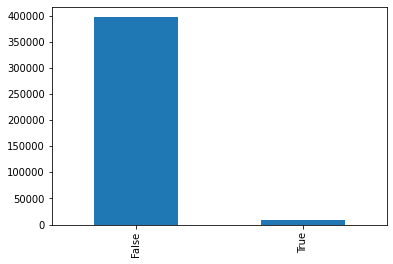

In [36]:
ax = df['Canceled'].value_counts().plot(kind='bar')

We have really few canceled orders. From now on we will consider only the not canceled ones, leaving the canceled for further analysis.

In [37]:
canceled = df[df['Canceled']]
main_data = df[~(df['Canceled'])]

del main_data['Canceled']
del canceled['Canceled']

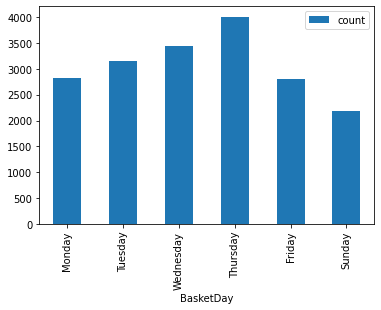

In [38]:
df_grouped = main_data.groupby(['BasketID', 'BasketDate', 'BasketDay'], as_index=False).agg({'CustomerID': 'count'})
del df_grouped['CustomerID']  # Dummy field.
df_grouped['weekday_num'] = df_grouped['BasketDate'].dt.dayofweek
df_grouped = (df_grouped.groupby(['weekday_num', 'BasketDay']).size().reset_index(name="count"))
df_grouped.plot.bar(x="BasketDay", y="count");
del df_grouped['weekday_num']

There are no sales on saturday.

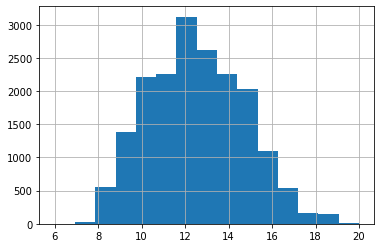

In [39]:
df_grouped = main_data.groupby(['BasketID', 'BasketDate', 'BasketDay'], as_index=False).agg({'CustomerID': 'count'})
del df_grouped['CustomerID']  # Dummy field.

hour = df_grouped['BasketDate'].dt.hour
df_grouped['Hour'] = hour

ax = df_grouped.Hour.hist(bins=15)

We can see that lunch time, especially from 12pm to 1pm, is preferred for the online shopping.

In [40]:
grouped = main_data.groupby(['CustomerID']).agg({'Total': 'sum'})
grouped = grouped.sort_values(by=['Total'], ascending=False)
total = grouped['Total'].sum()
total_20 = grouped['Total'].head(round(len(grouped) * 0.2)).sum()
total_20 / total

0.7384986526990065

We can see that the 20% of the customers give the 74% of the total income: it's almost following the 80/20 rule

## Saving cleaned dataset

In [41]:
main_data.to_csv('datasets/clean_data.csv')

## Creating indicators

In [42]:
customer_indicators = main_data.groupby(by='CustomerID', as_index=False).BasketDate.agg(['min', 'max'])
customer_indicators['Delta'] = (customer_indicators['max'] - customer_indicators['min']).dt.days + 1
del customer_indicators['min']
del customer_indicators['max']

In [43]:
# Shopping sessions.
#ss_total = not_canceled.groupby(['BasketID']).agg({'Qta': 'mean'})

#ax = ss_total.Qta.hist(bins=100000)
#ax.set_xlim((0, 100))

In [44]:
#ax = ss_total.plot.scatter(x='Qta', y='Total')

In [45]:
# total number of items purchased by a customer during its period of observation.

total_items = main_data.groupby('CustomerID').agg({'Qta': 'sum'})
total_items.columns = ['Total_items']

In [46]:
# total number of distinct items purchased by a customer during a period.

total_distinct_items = main_data.groupby('CustomerID')['ProdID'].nunique()
total_distinct_items = total_distinct_items.rename('Total_distinct_items')

In [47]:
# max number of items purchased by a customer during a shopping session.

temp = main_data.groupby(['BasketID','CustomerID']).agg({'Qta': 'sum'})
max_items = temp.groupby(['CustomerID']).agg({'Qta': 'max'})
max_items.columns = ['Max_items']
max_items

,Max_items
CustomerID,
12347,676
12348,1248
12349,630
12350,196
12352,125
...,...
18280,45
18281,54
18282,75


In [48]:
# Entropy on shopping date for customer predictability.

entropies = []

customer_list = main_data.groupby(['CustomerID', 'BasketDay'], as_index=False).agg({'BasketDay': 'count'})

last_customer = None
for index, row in customer_list.iterrows():
    if last_customer != row['CustomerID']:
        last_customer = row['CustomerID']
        data = customer_list[customer_list['CustomerID'] == row['CustomerID']]
        prob = data['BasketDay']
        entropy = stats.entropy(prob)
        entropies.append(entropy)

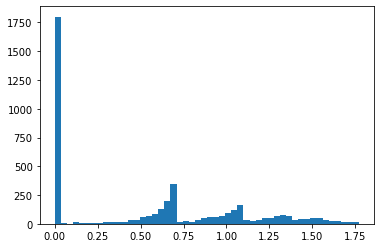

In [49]:
plt.hist(entropies, bins=50)
plt.show()

Most of the customer have 0 entropy (they made every purchase only on one day of the week), but this comes from the fact that a lot of them have only one purchase.

## Computing RFM indicators

In [50]:
# How many days since the last purchase?
recency = main_data.groupby(by='CustomerID', as_index=False)['BasketDate'].max()

last = main_data['BasketDate'].max() + dt.timedelta(days=1)

recency['Recency'] = recency['BasketDate'].apply(lambda x: (last - x).days)
del recency['BasketDate']
recency.head()

,CustomerID,Recency
0,12347,2
1,12348,75
2,12349,19
3,12350,310
4,12352,36


In [51]:
# How many times has a customer bought in this market?

frequency = main_data.groupby(by=['CustomerID'], as_index=False)['BasketID'].nunique()
frequency.columns = ['CustomerID', 'Frequency']
frequency.head()

,CustomerID,Frequency
0,12347,7
1,12348,4
2,12349,1
3,12350,1
4,12352,7


In [52]:
# How much has a customer spent?

monetary = main_data.groupby(by=['CustomerID'], as_index=False)['Total'].sum()
monetary.columns = ['CustomerID', 'Monetary']
monetary.head()

,CustomerID,Monetary
0,12347,4310.00
1,12348,1437.24
2,12349,1457.55
3,12350,294.40
4,12352,1385.74


In [53]:
median = main_data.groupby(by=['CustomerID', 'BasketID'], as_index=False)['Total'].sum()
median = median.groupby(by=['CustomerID'], as_index=False)['Total'].median()
median.columns = ['CustomerID', 'Median']
median.head()

,CustomerID,Median
0,12347,584.91
1,12348,298.50
2,12349,1457.55
3,12350,294.40
4,12352,226.25


In [54]:
# RFM table.

rfm = recency.merge(frequency.merge(monetary, on='CustomerID'), on='CustomerID')
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,12347,2,7,4310.00
1,12348,75,4,1437.24
2,12349,19,1,1457.55
3,12350,310,1,294.40
4,12352,36,7,1385.74


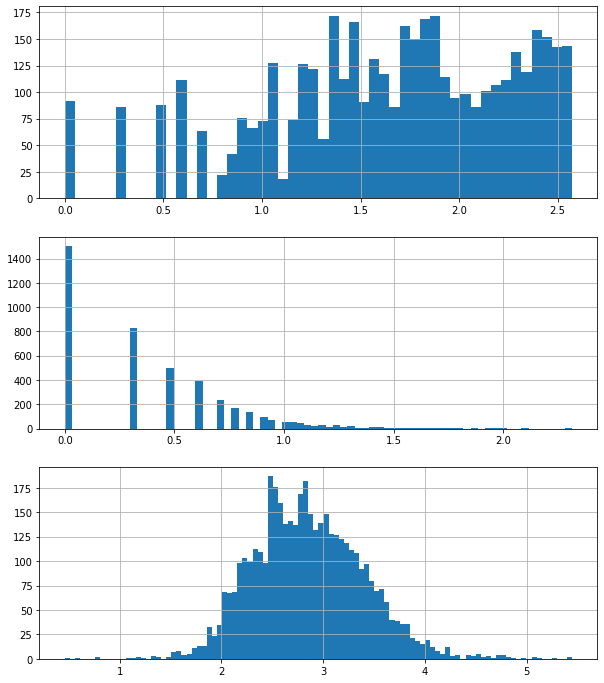

In [55]:
rfm_log = rfm[['Recency', 'Frequency', 'Monetary']].apply(np.log10, axis=1).round(3)

# plot the distribution of RFM values
f, ax = plt.subplots(figsize=(10, 12))
plt.subplot(3, 1, 1); rfm_log.Recency.hist(bins=50, label='Recency')
plt.subplot(3, 1, 2); rfm_log.Frequency.hist(bins=70, label='Frequency')
plt.subplot(3, 1, 3); rfm_log.Monetary.hist(bins=100, label='Monetary')
plt.show()

<AxesSubplot:>

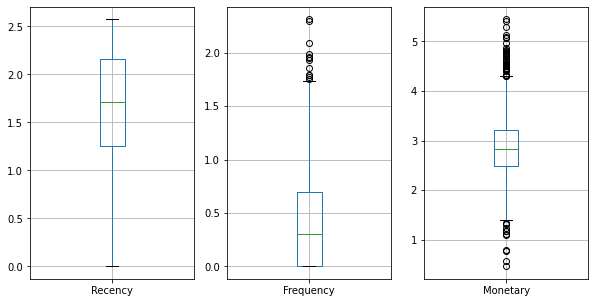

In [56]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
rfm_log.boxplot('Recency', ax=ax[0])
rfm_log.boxplot('Frequency', ax=ax[1])
rfm_log.boxplot('Monetary', ax=ax[2])

In [57]:
customer_indicators = customer_indicators.merge(rfm, on='CustomerID')
customer_indicators = customer_indicators.merge(total_items, on='CustomerID')
customer_indicators = customer_indicators.merge(total_distinct_items, on='CustomerID')
customer_indicators = customer_indicators.merge(max_items, on='CustomerID')
customer_indicators = customer_indicators.merge(median, on='CustomerID')
customer_indicators['Entropy'] = entropies

Text(0.5, 1.0, 'Correlation matrix')

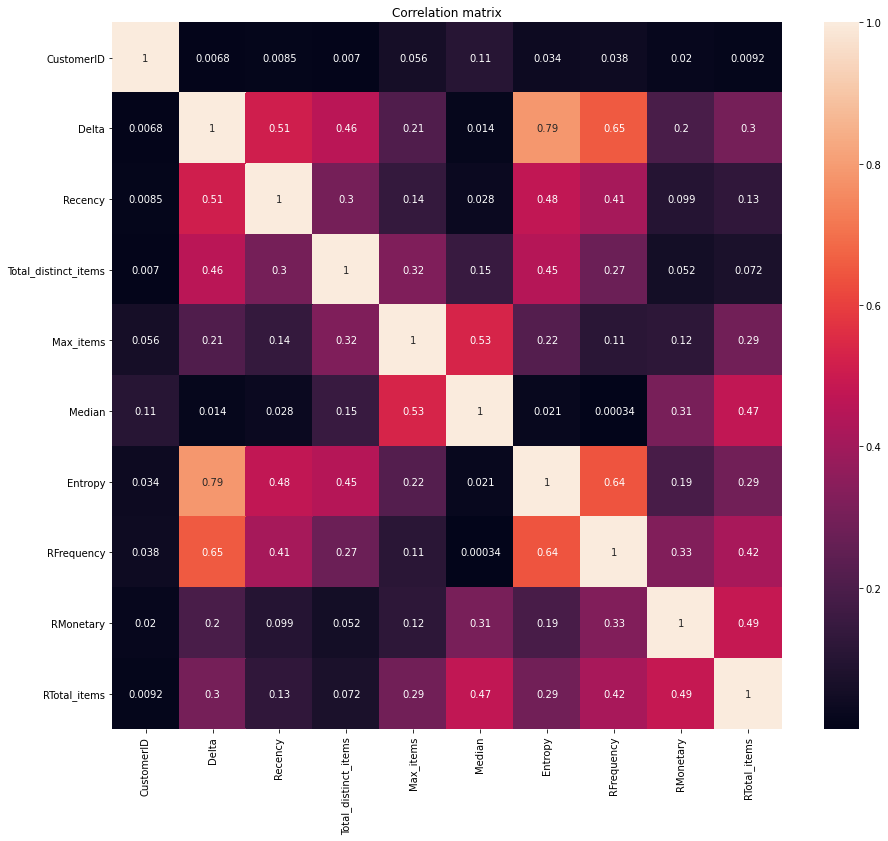

In [58]:
customer_indicators['RFrequency'] = customer_indicators['Frequency'] / customer_indicators['Delta']
customer_indicators['RMonetary'] = customer_indicators['Monetary'] / customer_indicators['Delta']
customer_indicators['RTotal_items'] = customer_indicators['Total_items'] / customer_indicators['Delta']

# Remove absolute attributes
del customer_indicators['Frequency']
del customer_indicators['Monetary']
del customer_indicators['Total_items']

f, ax = plt.subplots(figsize=(15, 13))
correlation = customer_indicators.corr().abs()
ax = sns.heatmap(correlation, annot=True)
plt.title("Correlation matrix")

## Outliers detection

<AxesSubplot:>

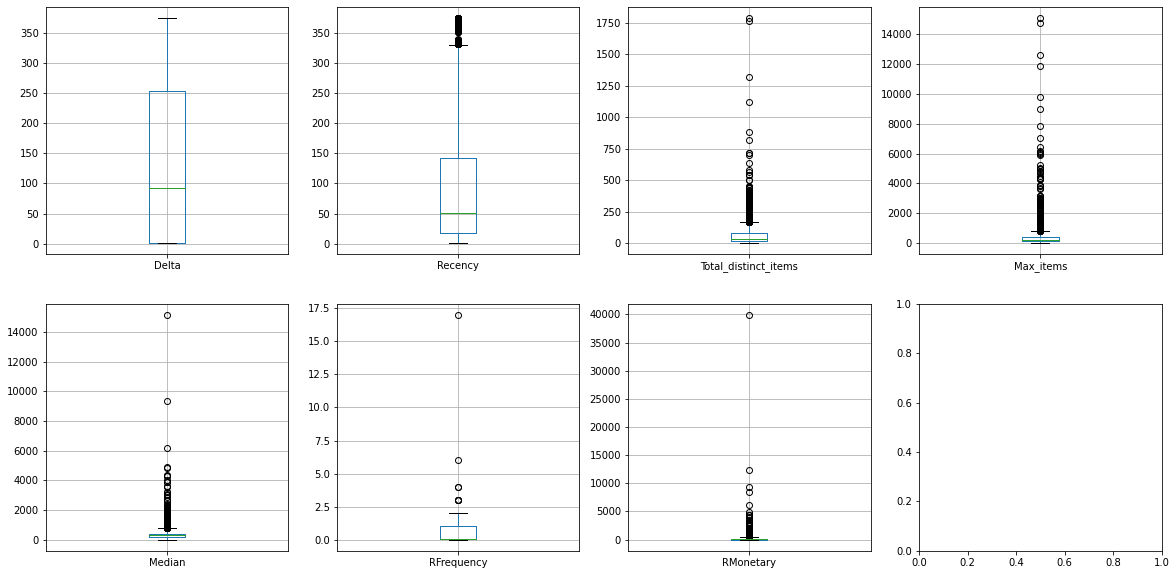

In [59]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
customer_indicators.boxplot('Delta', ax=ax[0][0])
customer_indicators.boxplot('Recency', ax=ax[0][1])
customer_indicators.boxplot('Total_distinct_items', ax=ax[0][2])
customer_indicators.boxplot('Max_items', ax=ax[0][3])

customer_indicators.boxplot('Median', ax=ax[1][0])
customer_indicators.boxplot('RFrequency', ax=ax[1][1])
customer_indicators.boxplot('RMonetary', ax=ax[1][2])

We check and remove the outliers in Median, RFrequency and RMonetary

In [60]:
customer_indicators[customer_indicators['Median'] > 6000]

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items
9,12357,1,33,131,2708,6207.67,0.000000,1.000000,6207.670000,2708.000000
195,12590,1,211,67,4282,9341.26,0.000000,1.000000,9341.260000,4282.000000
2501,15749,98,235,5,9014,15160.90,0.693147,0.030612,454.431633,183.959184


In [61]:
customer_indicators[customer_indicators['RFrequency'] > 2.5]

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items
1981,15060,1,8,80,124,78.62,0.244930,4.0,301.840,262.0
2010,15098,1,182,1,60,649.50,0.000000,3.0,39916.500,121.0
2623,15920,1,154,52,55,33.75,0.000000,3.0,163.550,94.0
2675,16000,1,3,9,4340,2046.00,0.000000,3.0,12393.700,5110.0
2764,16120,1,59,26,762,147.60,0.000000,4.0,1309.140,878.0
3793,17545,1,43,122,214,179.14,0.000000,3.0,645.960,341.0
4011,17850,2,372,21,141,91.76,0.595605,17.0,2695.605,866.5
4223,18139,1,18,35,1644,912.87,0.622627,6.0,8438.340,5557.0


In [62]:
customer_indicators[customer_indicators['RMonetary'] > 15000]

,CustomerID,Delta,Recency,Total_distinct_items,Max_items,Median,Entropy,RFrequency,RMonetary,RTotal_items
2010,15098,1,182,1,60,649.5,0.0,3.0,39916.5,121.0


In [63]:
customer_indicators.drop(customer_indicators[customer_indicators.Median > 6000].index, inplace=True)
customer_indicators.drop(customer_indicators[customer_indicators.RFrequency > 2.5].index, inplace=True)
customer_indicators.drop(customer_indicators[customer_indicators.RMonetary > 15000].index, inplace=True)

In [64]:
customer_indicators.to_csv('datasets/customer_indicators.csv')